# Τεχνικές Εξόρυξης Δεδομένων Εαρινό εξάμηνο 2022-2023
## 1η Άσκηση
### Αλέξανδρος Αλατζάς 1115201900005

###Εισαγωγή βιβλιοθηκών και διάβασμα του αρχείου csv

In [39]:
# Mount our google drive in google colab 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from yellowbrick.cluster import KElbowVisualizer

Εισάγουμε τον πίνακα marketing_campaign σε ένα dataframe με τίτλο campaign

In [41]:
# The dataframe is named campaign
location = r'/content/gdrive/MyDrive/DataMining/Project1/marketing_campaign.csv'
campaign = pd.read_csv(location, sep='\t')

### **Ζητούμενο 1**: Προεπεξεργασία/Καθάρισμα

In [42]:
# Drop rows with empty or Nan values
campaign = campaign.dropna()

# Convert date columns to DateTime objects
campaign['Dt_Customer'] = pd.to_datetime(campaign['Dt_Customer'], dayfirst=True)

# Check if there are any dtype: object columns
object_cols = campaign.select_dtypes(include=['object']).columns
print(object_cols)

Index(['Education', 'Marital_Status'], dtype='object')


###**Ζητούμενο 2**: Πλήθος τιμών ανά κατηγορία

['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
['Single' 'Together' 'Married' 'Divorced' 'Widow']


<Axes: xlabel='Marital_Status'>

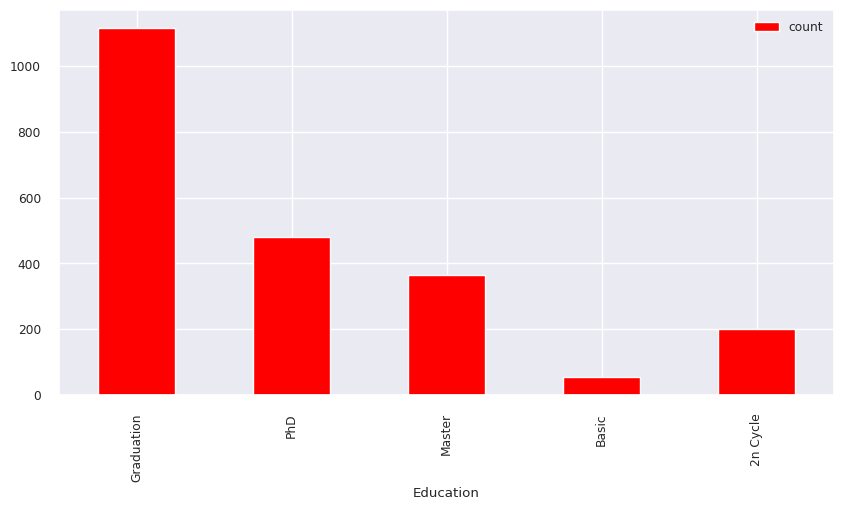

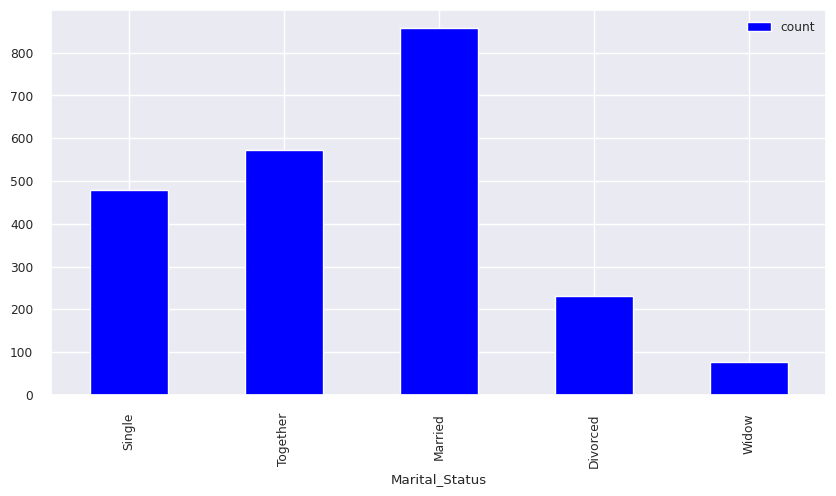

In [43]:
# Print the unique values of 'Marital_Status' and 'Education columns
print(campaign['Education'].unique())
print(campaign['Marital_Status'].unique())

# Change [Alone, Absurd, YOLO] values to 'Single'
campaign['Marital_Status'] = campaign['Marital_Status'].replace(['Alone', 'Absurd', 'YOLO'], 'Single')

print(campaign['Marital_Status'].unique())

# New dataframe to obtain 'ID' and 'Education' status
id_edu = campaign[['ID', 'Education']]
id_edu = id_edu.drop_duplicates(subset=['ID'])

# Count every level of education
id_edu['count'] = id_edu.groupby(['Education'])['ID'].transform('count')

# Drop duplicate levels of education
id_edu = id_edu.drop_duplicates(subset=['Education'])
id_edu = id_edu[['Education', 'count']]

# Bar plot the data
id_edu.plot(x = 'Education', y = 'count', kind = 'bar', figsize = (10,5), color = 'red')


# Same procedure for 'Marital Status'
id_marital = campaign[['ID', 'Marital_Status']]
id_marital = id_marital.drop_duplicates(subset=['ID'])

id_marital['count'] = id_marital.groupby(['Marital_Status'])['ID'].transform('count')

id_marital = id_marital.drop_duplicates(subset=['Marital_Status'])
id_marital = id_marital[['Marital_Status', 'count']]

id_marital.plot(x = 'Marital_Status', y = 'count', kind = 'bar', figsize = (10,5), color = 'blue')

### **Ζητούμενο 3**: Δημιουργία νέων χαρακτηριστικών

**Α**. Δημιουργία ενός χαρακτηριστικού ("Customer_For") που αντιπροσωπεύει τον αριθμό
των ημερών που οι πελάτες άρχισαν να ψωνίζουν στο κατάστημα σε σχέση με την
τελευταία καταγεγραμμένη ημερομηνία (Recency).

In [44]:
# Today's date / Code snippet from AI course
today = datetime.date.today()
today = today.strftime('%Y-%m-%d')
today = datetime.datetime.strptime(today, '%Y-%m-%d')

# Subtract the date of the customer's first enrollment and the number of days
#  since his last purchase from today's date
for col in campaign:
    # Number of days passed since customer's first enrollment
    enroll_days = today - campaign['Dt_Customer']
    campaign['Customer_For'] = enroll_days - pd.to_timedelta(campaign['Recency'], unit='D')

# Prints 
print('enroll_days\n', enroll_days)
campaign['Customer_For'] = campaign['Customer_For'].dt.days
campaign[['Recency', 'Customer_For']]

enroll_days
 0      3904 days
1      3354 days
2      3553 days
3      3380 days
4      3402 days
          ...   
2235   3622 days
2236   3260 days
2237   3396 days
2238   3397 days
2239   3863 days
Name: Dt_Customer, Length: 2216, dtype: timedelta64[ns]


,Recency,Customer_For
0,58,3846
1,38,3316
2,26,3527
3,26,3354
4,94,3308
...,...,...
2235,46,3576
2236,56,3204
2237,91,3305
2238,8,3389


**Β**. Εξαγωγή της ηλικίας "Age" ενός πελάτη με βάση το "Year_Birth" που υποδεικνύει το
έτος γέννησης του αντίστοιχου ατόμου.

In [45]:
# Subtract the year of birth from current year
for col in campaign:
    campaign['Age'] = today.year - campaign['Year_Birth']
campaign[['Year_Birth', 'Age']]

,Year_Birth,Age
0,1957,66
1,1954,69
2,1965,58
3,1984,39
4,1981,42
...,...,...
2235,1967,56
2236,1946,77
2237,1981,42
2238,1956,67


**Γ**. Δημιουργήστε ένα άλλο χαρακτηριστικό "Spent" που υποδεικνύει το συνολικό ποσό
που ξόδεψε ο πελάτης σε όλες τις κατηγορίες σε διάστημα δύο ετών.

In [46]:
# Add every amount in the last 2 years
for col in campaign:
    campaign['Spent'] = campaign['MntWines'] + campaign['MntFruits'] + campaign['MntMeatProducts'] \
                          + campaign['MntFishProducts'] + campaign['MntSweetProducts'] + campaign['MntGoldProds']
    campaign['Spent'] = campaign['Spent'].astype(int)
campaign[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Spent']]

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,Spent
0,635,88,546,172,88,88,1617
1,11,1,6,2,1,6,27
2,426,49,127,111,21,42,776
3,11,4,20,10,3,5,53
4,173,43,118,46,27,15,422
...,...,...,...,...,...,...,...
2235,709,43,182,42,118,247,1341
2236,406,0,30,0,0,8,444
2237,908,48,217,32,12,24,1241
2238,428,30,214,80,30,61,843


**Δ**. Δημιουργήστε ένα χαρακτηριστικό "Παιδιά" για να δηλώσετε το σύνολο των παιδιών σε
ένα νοικοκυριό, δηλαδή τα παιδιά και τους εφήβους.
Εδώ, ονομάζουμε το χαρακτηριστικό ως 'Kids' για ενιαία αναπαράσταση.

In [47]:
# Add kids and teenagers to find total children of a household
for col in campaign:
    campaign['Kids'] = campaign['Kidhome'] + campaign['Teenhome']
campaign[['Kidhome', 'Teenhome', 'Kids']]

,Kidhome,Teenhome,Kids
0,0,0,0
1,1,1,2
2,0,0,0
3,1,0,1
4,1,0,1
...,...,...,...
2235,0,1,1
2236,2,1,3
2237,0,0,0
2238,0,1,1


**Ε**. Για να αποκτήσετε περαιτέρω σαφήνεια του νοικοκυριού, δημιουργήστε ένα
χαρακτηριστικό με ένδειξη "Family_Size" που δείχνει το συνολικό αριθμό των ατόμων σε
ένα νοικοκυριό

In [48]:
# Depending on 'Marital_Status' we add to the number of children either one parent or two
for col in campaign:
    campaign.loc[(campaign['Marital_Status'] == 'Together') | (campaign['Marital_Status'] == 'Married'), 'Family_Size'] = campaign['Kids'] + 2
    campaign.loc[(campaign['Marital_Status'] != 'Together') & (campaign['Marital_Status'] != 'Married'), 'Family_Size'] = campaign['Kids'] + 1
campaign['Family_Size'] = campaign['Family_Size'].astype('int64')
campaign[['Marital_Status', 'Kids', 'Family_Size']]

,Marital_Status,Kids,Family_Size
0,Single,0,1
1,Single,2,3
2,Together,0,2
3,Together,1,3
4,Married,1,3
...,...,...,...
2235,Married,1,3
2236,Together,3,5
2237,Divorced,0,1
2238,Together,1,3


**Στ**. Δημιουργήστε ένα χαρακτηριστικό "Is_Parent" που δηλώνει αν ένας πελάτης είναι και
γονιός

In [49]:
# Attribute 'Is_Parent' will be defined as boolean
for col in campaign:
    campaign.loc[(campaign['Kids'] > 0), 'Is_Parent'] = 1
    campaign.loc[(campaign['Kids'] == 0), 'Is_Parent'] = 0
campaign['Is_Parent'] = campaign['Is_Parent'].astype('int64')
campaign[['Kids', 'Is_Parent']]

,Kids,Is_Parent
0,0,0
1,2,1
2,0,0
3,1,1
4,1,1
...,...,...
2235,1,1
2236,3,1
2237,0,0
2238,1,1


**Ζ**. Δημιουργήστε ένα άλλο χαρακτηριστικό "Living_With" χρησιμοποιώντας το
"Marital_Status" για να εξάγετε την κατάσταση διαβίωσης των ζευγαριών. Συγκεκριμένα
το χαρακτηριστικό αυτό πρέπει να έχει δύο τιμές, "Partner" και "Alone".

In [50]:
# Similar to question E, we define the value of 'Living_With' from 'Marital_Status'
for col in campaign:
    campaign.loc[(campaign['Marital_Status'] == 'Together') | (campaign['Marital_Status'] == 'Married'), 'Living_With'] = 'Partner'
    campaign.loc[(campaign['Marital_Status'] != 'Together') & (campaign['Marital_Status'] != 'Married'), 'Living_With'] = 'Alone'
campaign[['Marital_Status', 'Living_With']]

,Marital_Status,Living_With
0,Single,Alone
1,Single,Alone
2,Together,Partner
3,Together,Partner
4,Married,Partner
...,...,...
2235,Married,Partner
2236,Together,Partner
2237,Divorced,Alone
2238,Together,Partner


**Η**. Δημιουργήστε τη στήλη “Age Group” χρησιμοποιώντας τη στήλη “Age”, η οποία να
ομαδοποιεί τις ηλικίες στις παρακάτω τιμές "21-30", "31-40", "41-50", "51-60", "61-70",
"71-80", ">80"

In [51]:
# Match customer's age to the according age group
for col in campaign:
    campaign.loc[(campaign['Age'] >= 21) & (campaign['Age'] <= 30), 'Age Group'] = '21-30'
    campaign.loc[(campaign['Age'] >= 31) & (campaign['Age'] <= 40), 'Age Group'] = '31-40'
    campaign.loc[(campaign['Age'] >= 41) & (campaign['Age'] <= 50), 'Age Group'] = '41-50'
    campaign.loc[(campaign['Age'] >= 51) & (campaign['Age'] <= 60), 'Age Group'] = '51-60'
    campaign.loc[(campaign['Age'] >= 61) & (campaign['Age'] <= 70), 'Age Group'] = '61-70'
    campaign.loc[(campaign['Age'] >= 71) & (campaign['Age'] <= 80), 'Age Group'] = '71-80'
    campaign.loc[(campaign['Age'] > 80), 'Age Group'] = '>80'
campaign[['Age', 'Age Group']]

,Age,Age Group
0,66,61-70
1,69,61-70
2,58,51-60
3,39,31-40
4,42,41-50
...,...,...
2235,56,51-60
2236,77,71-80
2237,42,41-50
2238,67,61-70


###**Ζητούμενο 4**: Διαγραφή ακραίων τιμών
Παρατηρώντας τα δεδομένα, θα ψάξουμε για ακραίες τιμές μόνο σε χαρακτηριστικά με αριθμητικές τιμές και πιο συγκεκριμένα σε χαρακτηριστικά που θεωρούμε πως έχει νόημα να διαγράψουμε. (Δεν κοιτάμε χαρακτηριστικά με σταθερές τιμές ή τιμές [0,1])

Ορίζουμε συνάρτηση για τον εντοπισμό ακραίων τιμών με threshold 3.

In [52]:
# We use the common threshold of 3 for normal distribution
def outliers(dataframe, feature) :
    new_dataframe = dataframe.copy()
    new_dataframe['x-Mean'] = abs(new_dataframe[feature] - new_dataframe[feature].mean())
    new_dataframe['3*std'] = 3*new_dataframe[feature].std()  
    new_dataframe['Outlier'] = abs(new_dataframe[feature] - new_dataframe[feature].mean()) > 3*new_dataframe[feature].std()
    return new_dataframe

Άρχικά, εξετάζουμε το χαρακτηριστικό 'Age' (δεν χρειάζεται εξέταση και του 'Year_Birth')

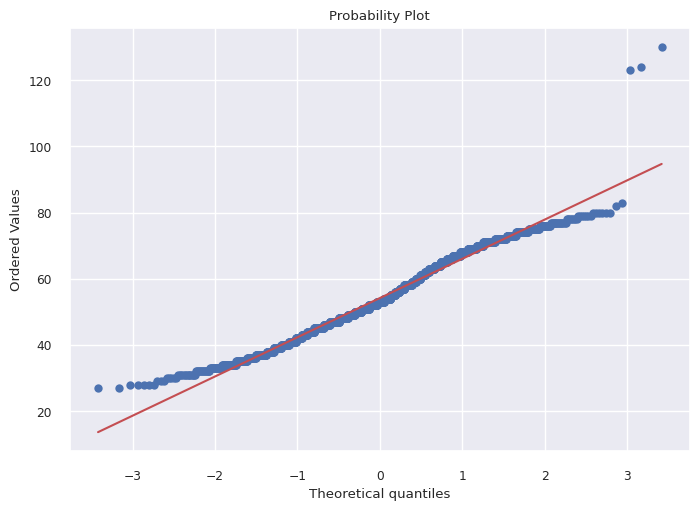

,Age,x-Mean,3*std,Outlier
0,66,11.820397,35.956662,False
1,69,14.820397,35.956662,False
2,58,3.820397,35.956662,False
3,39,15.179603,35.956662,False
4,42,12.179603,35.956662,False
...,...,...,...,...
2235,56,1.820397,35.956662,False
2236,77,22.820397,35.956662,False
2237,42,12.179603,35.956662,False
2238,67,12.820397,35.956662,False


In [53]:
# We plot the distribution of 'Age' attribute to inspect for outliers
stats.probplot(campaign['Age'], dist="norm", plot=plt)
plt.show()

age = outliers(campaign, 'Age')
age[['Age', 'x-Mean', '3*std', 'Outlier']]

Διαγράφουμε από τα δεδομένα τις ακραίες τιμές

In [54]:
campaign = campaign[~age['Outlier']]
campaign[['ID', 'Age']]

,ID,Age
0,5524,66
1,2174,69
2,4141,58
3,6182,39
4,5324,42
...,...,...
2235,10870,56
2236,4001,77
2237,7270,42
2238,8235,67


Εξετάζουμε το χαρακτηριστικό 'Customer_For' και βλέπουμε ότι δεν υπάρχουν ακραίες τιμές

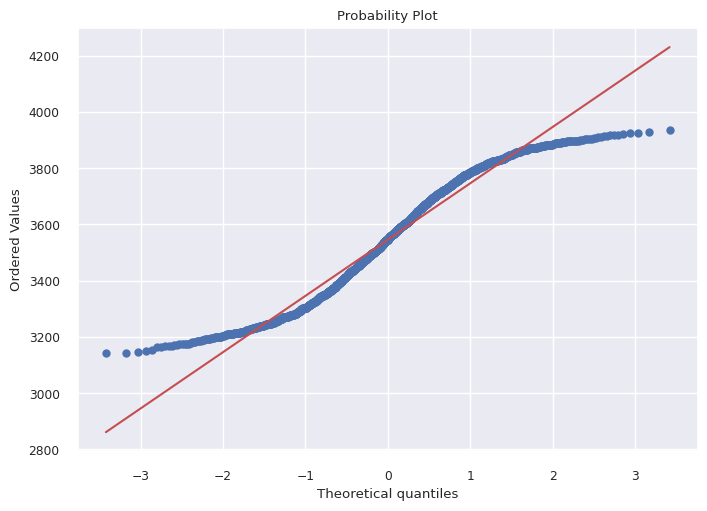

,Customer_For,x-Mean,3*std,Outlier
0,3846,300.276096,611.322737,False
1,3316,229.723904,611.322737,False
2,3527,18.723904,611.322737,False
3,3354,191.723904,611.322737,False
4,3308,237.723904,611.322737,False
...,...,...,...,...
2235,3576,30.276096,611.322737,False
2236,3204,341.723904,611.322737,False
2237,3305,240.723904,611.322737,False
2238,3389,156.723904,611.322737,False


In [55]:
stats.probplot(campaign['Customer_For'], dist="norm", plot=plt)
plt.show()

income = outliers(campaign, 'Customer_For')
income[['Customer_For', 'x-Mean', '3*std', 'Outlier']]

Εξετάζουμε το χαρακτηριστικό 'Income'

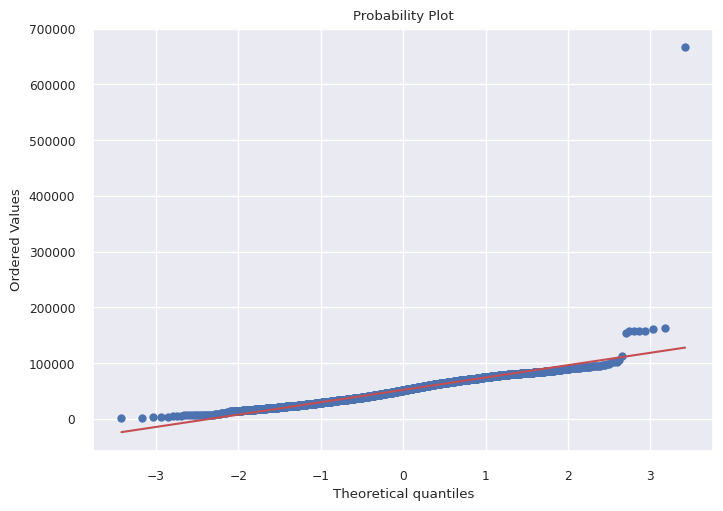

,Income,x-Mean,3*std,Outlier
0,58138.0,5901.418437,75535.809142,False
1,46344.0,5892.581563,75535.809142,False
2,71613.0,19376.418437,75535.809142,False
3,26646.0,25590.581563,75535.809142,False
4,58293.0,6056.418437,75535.809142,False
...,...,...,...,...
2235,61223.0,8986.418437,75535.809142,False
2236,64014.0,11777.418437,75535.809142,False
2237,56981.0,4744.418437,75535.809142,False
2238,69245.0,17008.418437,75535.809142,False


In [56]:
stats.probplot(campaign['Income'], dist="norm", plot=plt)
plt.show()

income = outliers(campaign, 'Income')
income[['Income', 'x-Mean', '3*std', 'Outlier']]

Διαγράφουμε από τα δεδομένα τις ακραίες τιμές

In [57]:
campaign = campaign[~income['Outlier']]
campaign[['ID', 'Income']]

,ID,Income
0,5524,58138.0
1,2174,46344.0
2,4141,71613.0
3,6182,26646.0
4,5324,58293.0
...,...,...
2235,10870,61223.0
2236,4001,64014.0
2237,7270,56981.0
2238,8235,69245.0


Εξετάζουμε το χαρακτηριστικό 'Recency' και βλέπουμε ότι δεν υπάρχουν ακραίες τιμές

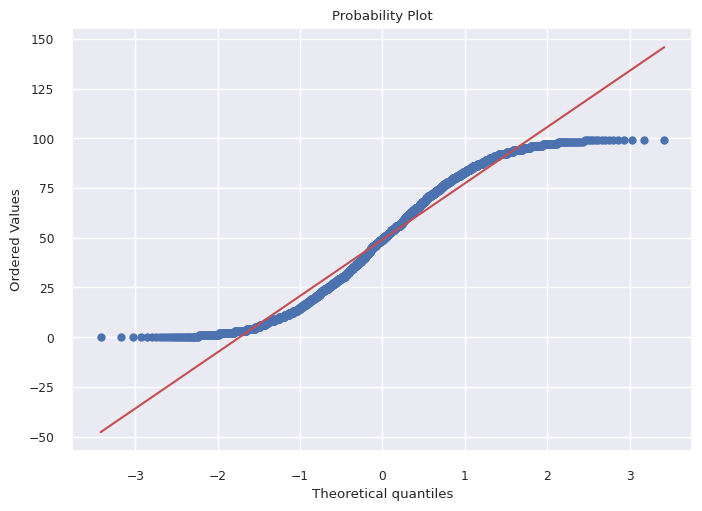

,Recency,x-Mean,3*std,Outlier
0,58,8.99093,86.796334,False
1,38,11.00907,86.796334,False
2,26,23.00907,86.796334,False
3,26,23.00907,86.796334,False
4,94,44.99093,86.796334,False
...,...,...,...,...
2235,46,3.00907,86.796334,False
2236,56,6.99093,86.796334,False
2237,91,41.99093,86.796334,False
2238,8,41.00907,86.796334,False


In [58]:
stats.probplot(campaign['Recency'], dist="norm", plot=plt)
plt.show()

recency = outliers(campaign, 'Recency')
recency[['Recency', 'x-Mean', '3*std', 'Outlier']]

Εξετάζουμε το χαρακτηριστικό 'Family_Size' και βλέπουμε ότι δεν υπάρχουν ακραίες τιμές

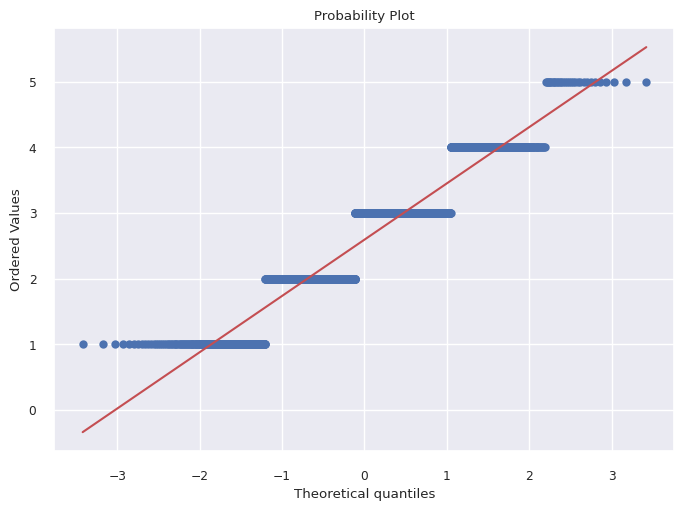

,Family_Size,x-Mean,3*std,Outlier
0,1,1.593651,2.718592,False
1,3,0.406349,2.718592,False
2,2,0.593651,2.718592,False
3,3,0.406349,2.718592,False
4,3,0.406349,2.718592,False
...,...,...,...,...
2235,3,0.406349,2.718592,False
2236,5,2.406349,2.718592,False
2237,1,1.593651,2.718592,False
2238,3,0.406349,2.718592,False


In [59]:
stats.probplot(campaign['Family_Size'], dist="norm", plot=plt)
plt.show()

family_size = outliers(campaign, 'Family_Size')
family_size[['Family_Size', 'x-Mean', '3*std', 'Outlier']]

Στα δεδομένα υπάρχουν 6 χαρακτηριστικά με χρηματικά ποσά που δαπανήθηκαν τα τελευταία 2 χρόνια σε διαφορετικές κατηγορίες τροφίμων. Θεωρούμε πιο ρεαλιστικό να εξετάσουμε το χαρακτηριστικό 'Spent', το οποίο δίνει την συνολική εικόνα κατανάλωσης ενός πελάτη, καθώς μας παρέχει ασφάλεια στην περίπτωση που ένας πελάτης έχει ισχυρή προτίμηση σε μια κατηγορία τροφίμων και ελάχιστη σε μία άλλη (η συνολική του κατανάλωση δεν αποτελεί ακραία τιμή).

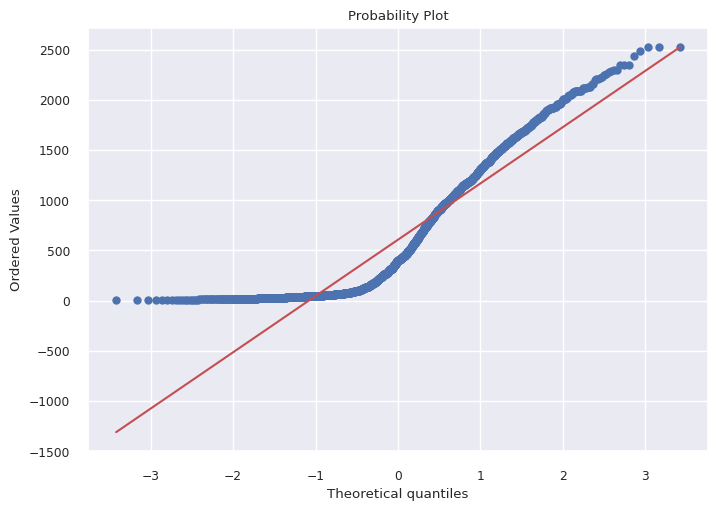

,Spent,x-Mean,3*std,Outlier
0,1617,1010.178231,1805.025852,False
1,27,579.821769,1805.025852,False
2,776,169.178231,1805.025852,False
3,53,553.821769,1805.025852,False
4,422,184.821769,1805.025852,False
...,...,...,...,...
2235,1341,734.178231,1805.025852,False
2236,444,162.821769,1805.025852,False
2237,1241,634.178231,1805.025852,False
2238,843,236.178231,1805.025852,False


In [60]:
stats.probplot(campaign['Spent'], dist="norm", plot=plt)
plt.show()

spent = outliers(campaign, 'Spent')
spent[['Spent', 'x-Mean', '3*std', 'Outlier']]

Διαγράφουμε από τα δεδομένα τις ακραίες τιμές

In [61]:
campaign = campaign[~spent['Outlier']]
campaign[['ID', 'Spent']]

,ID,Spent
0,5524,1617
1,2174,27
2,4141,776
3,6182,53
4,5324,422
...,...,...
2235,10870,1341
2236,4001,444
2237,7270,1241
2238,8235,843


Εξετάζουμε το χαρακτηριστικό 'NumDealsPurchases'. Εδώ παρατηρούμε ότι οι τιμές ακολουθούν εκθετική κατανομή.

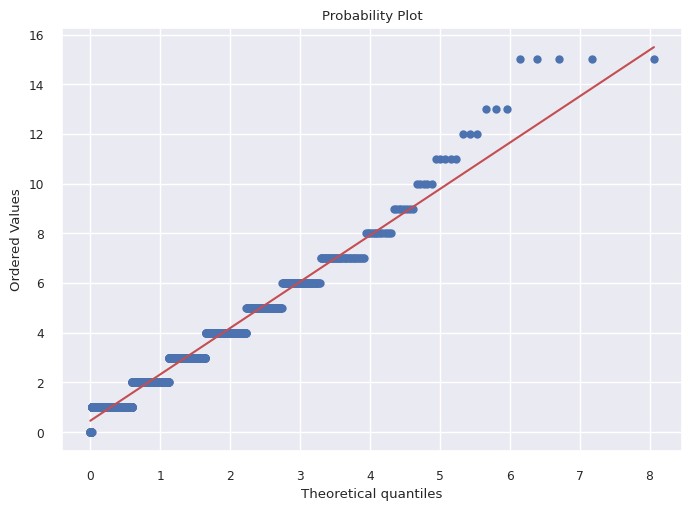

,NumDealsPurchases,Outlier
0,3,False
1,2,False
2,1,False
3,2,False
4,5,False
...,...,...
2235,2,False
2236,7,False
2237,1,False
2238,2,False


In [62]:
stats.probplot(campaign['NumDealsPurchases'], dist="expon", plot=plt)
plt.show()

deals = campaign.copy()

for col in campaign:
    deals.loc[deals['NumDealsPurchases'] > 10, 'Outlier'] = True
    deals.loc[deals['NumDealsPurchases'] <= 10, 'Outlier'] = False

deals['Outlier'] = deals['Outlier'].astype(bool)

deals[['NumDealsPurchases', 'Outlier']]

Παρατηρώντας τη γραφική παράσταση θα αποφασίσουμε να διαγράψουμε τις τιμές μεγαλύτερες από 11.

In [63]:
campaign = campaign[~deals['Outlier']]
campaign[['ID', 'NumDealsPurchases']]

,ID,NumDealsPurchases
0,5524,3
1,2174,2
2,4141,1
3,6182,2
4,5324,5
...,...,...
2235,10870,2
2236,4001,7
2237,7270,1
2238,8235,2


Εξετάζουμε το χαρακτηριστικό 'NumWebPurchases'

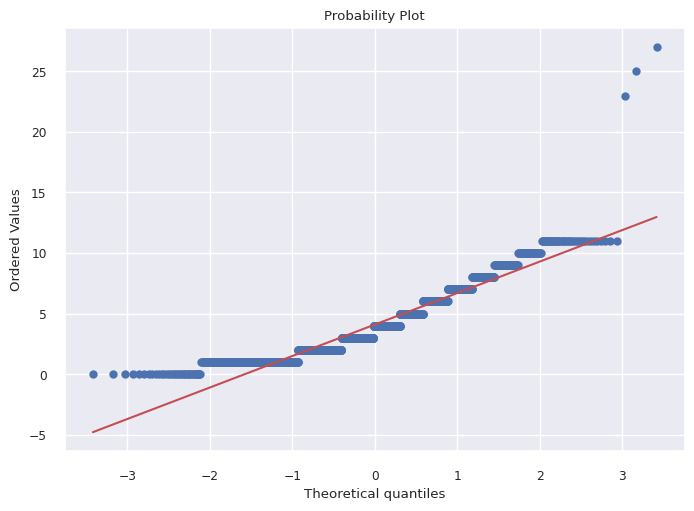

,NumWebPurchases,Outlier
0,8,False
1,1,False
2,8,False
3,2,False
4,5,False
...,...,...
2235,9,False
2236,8,False
2237,2,False
2238,6,False


In [64]:
stats.probplot(campaign['NumWebPurchases'], dist="norm", plot=plt)
plt.show()

web = outliers(campaign, 'NumWebPurchases')
web[['NumWebPurchases', 'Outlier']]

Διαγράφουμε από τα δεδομένα τις ακραίες τιμές

In [65]:
campaign = campaign[~web['Outlier']]
campaign[['ID', 'NumWebPurchases']]

,ID,NumWebPurchases
0,5524,8
1,2174,1
2,4141,8
3,6182,2
4,5324,5
...,...,...
2235,10870,9
2236,4001,8
2237,7270,2
2238,8235,6


Εξετάζουμε το χαρακτηριστικό 'NumCatalogPurchases'

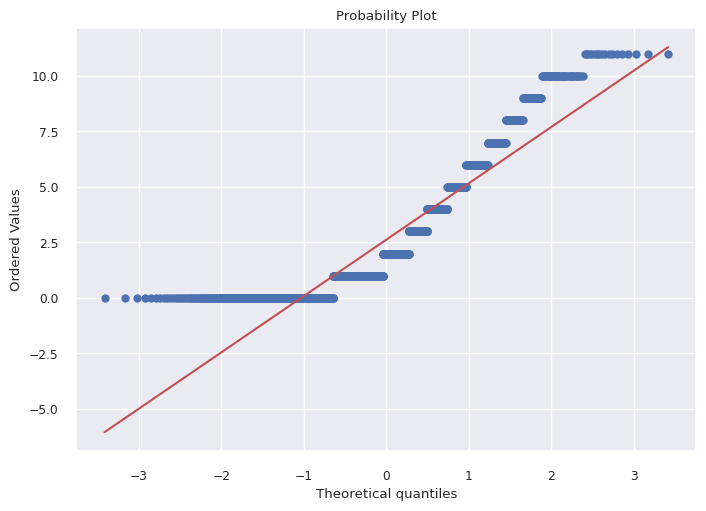

,NumCatalogPurchases,Outlier
0,10,False
1,1,False
2,2,False
3,0,False
4,3,False
...,...,...
2235,3,False
2236,2,False
2237,3,False
2238,5,False


In [66]:
stats.probplot(campaign['NumCatalogPurchases'], dist="norm", plot=plt)
plt.show()

catalog = outliers(campaign, 'NumCatalogPurchases')
catalog[['NumCatalogPurchases', 'Outlier']]

Διαγράφουμε από τα δεδομένα τις ακραίες τιμές

In [67]:
campaign = campaign[~catalog['Outlier']]
campaign[['ID', 'NumCatalogPurchases']]

,ID,NumCatalogPurchases
0,5524,10
1,2174,1
2,4141,2
3,6182,0
4,5324,3
...,...,...
2235,10870,3
2236,4001,2
2237,7270,3
2238,8235,5


Εξετάζουμε το χαρακτηριστικό 'NumStorePurchases' και βλέπουμε ότι δεν έχει ακραίες τιμές

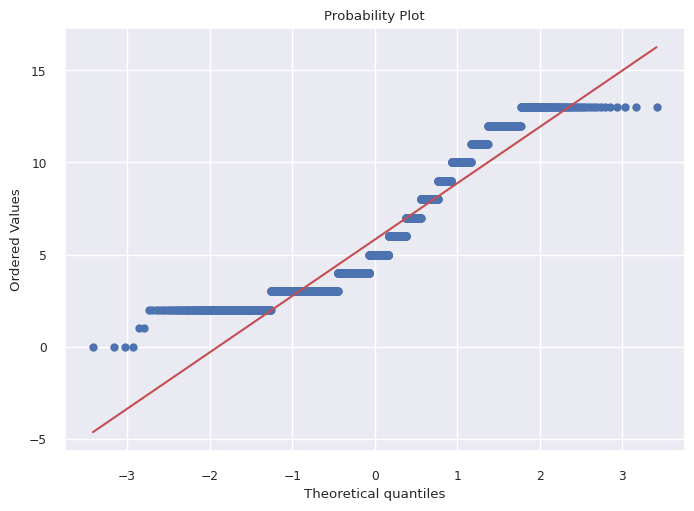

,NumStorePurchases,Outlier
0,4,False
1,2,False
2,10,False
3,4,False
4,6,False
...,...,...
2235,4,False
2236,5,False
2237,13,False
2238,10,False


In [68]:
stats.probplot(campaign['NumStorePurchases'], dist="norm", plot=plt)
plt.show()

store = outliers(campaign, 'NumStorePurchases')
store[['NumStorePurchases', 'Outlier']]

Εξετάζουμε το χαρακτηριστικό 'NumWebVisitsMonth'

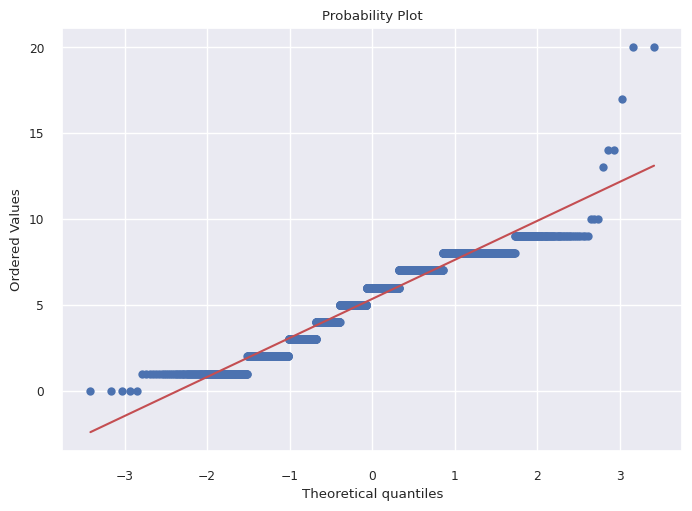

,NumWebVisitsMonth,Outlier
0,7,False
1,5,False
2,4,False
3,6,False
4,5,False
...,...,...
2235,5,False
2236,7,False
2237,6,False
2238,3,False


In [69]:
stats.probplot(campaign['NumWebVisitsMonth'], dist="norm", plot=plt)
plt.show()

web_visits = outliers(campaign, 'NumWebVisitsMonth')
web_visits[['NumWebVisitsMonth', 'Outlier']]

Διαγράφουμε από τα δεδομένα τις ακραίες τιμές

In [70]:
campaign = campaign[~web_visits['Outlier']]
campaign[['ID', 'NumWebVisitsMonth']]

,ID,NumWebVisitsMonth
0,5524,7
1,2174,5
2,4141,4
3,6182,6
4,5324,5
...,...,...
2235,10870,5
2236,4001,7
2237,7270,6
2238,8235,3


###**Ζητούμενο 5**: Συσχέτιση μεταξύ χαρακτηριστικών με heatmap διάγραμμα

<Axes: >

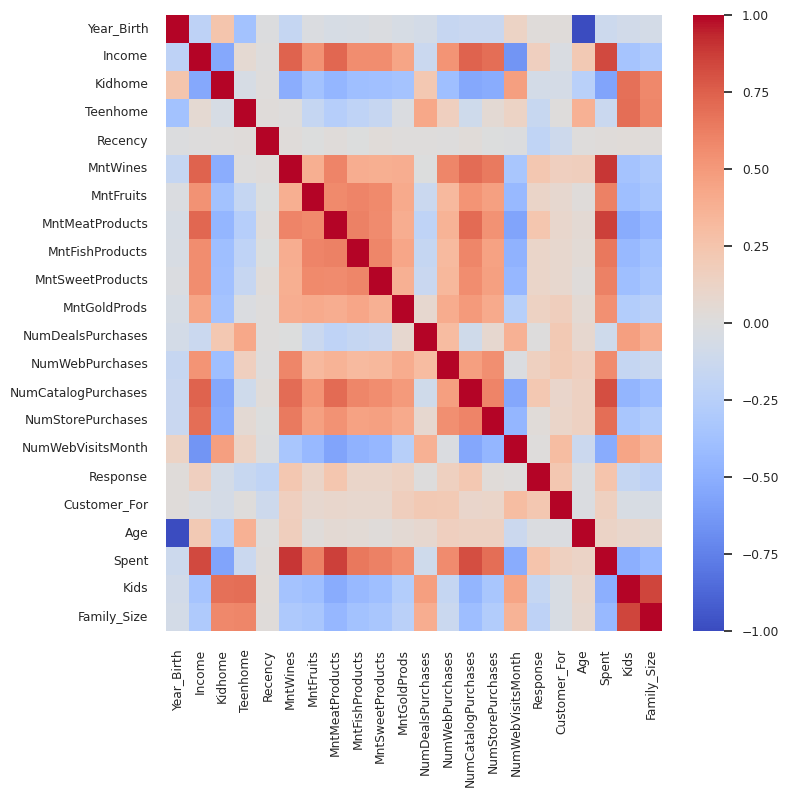

In [71]:
# Extra categorical attributes to drop
cat_cols = ['ID', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', \
                'AcceptedCmp5', 'Z_CostContact', 'Z_Revenue', 'Complain', 'Is_Parent']

# Include numeric attributes only
hm_campaign = campaign.copy()
hm_campaign = hm_campaign.drop(cat_cols, axis=1)
corr_matrix = hm_campaign.corr(numeric_only = True)

# Heatmap
sns.set(font_scale=0.8)
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, cmap='coolwarm')

###**Ζητούμενο 6**: Γραφήματα

1. Σε ποιά κατηγορία Marital_Status ανήκει το μεγαλύτερο ποσοστό των πελατών της
εταιρείας;

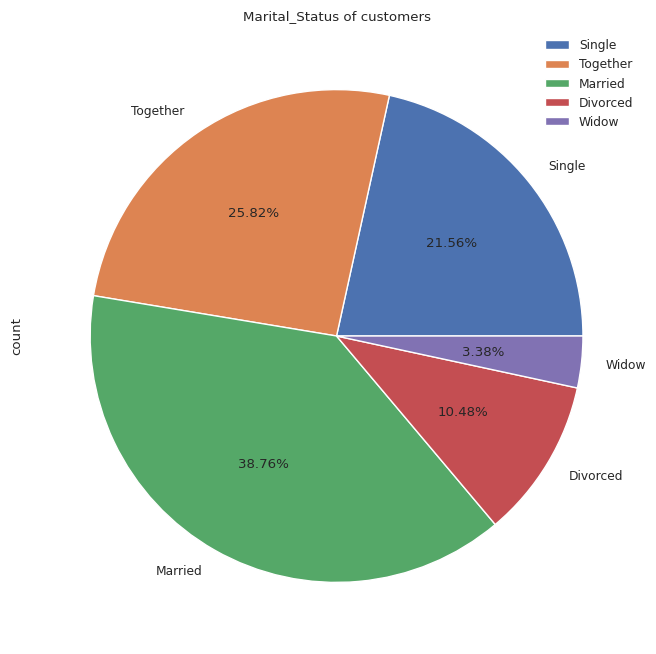

In [72]:
# Create new dataframe with 'Marital_Status' and 'ID'
id_marital = campaign[['ID', 'Marital_Status']].copy()
id_marital = id_marital.drop_duplicates(subset=['ID'])

# Count every 'Marital_Status'
id_marital['count'] = id_marital.groupby(['Marital_Status'])['ID'].transform('count')

# Drop duplicates
id_marital = id_marital.drop_duplicates(subset=['Marital_Status'])
id_marital = id_marital[['Marital_Status', 'count']]

# Pie plot data
id_marital.plot.pie(y='count', labels=id_marital['Marital_Status'], figsize=(8,8), autopct='%1.2f%%')
plt.title(label='Marital_Status of customers')
plt.show()

Παρατήρηση: Το μεγαλύτερο ποσοστό των πελατών είναι παντρεμένοι.

2. Πόσοι πελάτες έχουν κάνει Complain ;

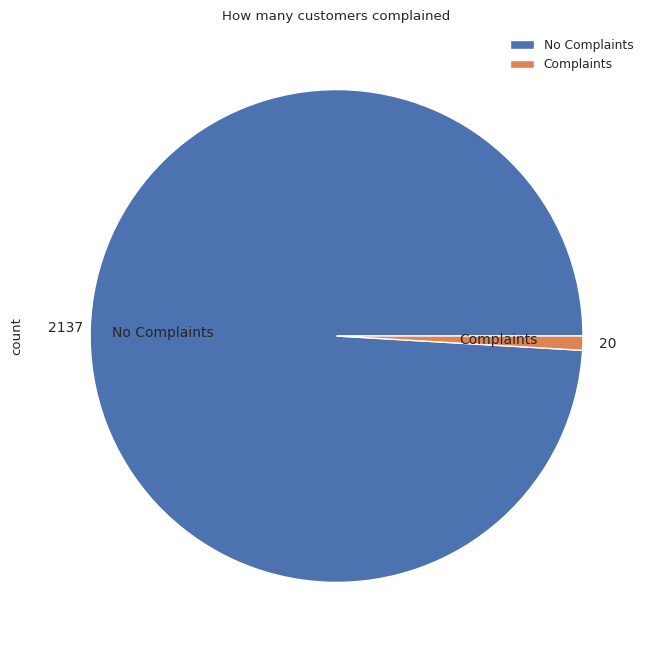

In [73]:
id_complain = campaign[['ID', 'Complain']].copy()
id_complain = id_complain.drop_duplicates(subset=['ID'])

id_complain['count'] = id_complain.groupby(['Complain'])['ID'].transform('count')

id_complain = id_complain.drop_duplicates(subset=['Complain'])
id_complain = id_complain[['Complain', 'count']]

total = sum(id_complain['count'])

id_complain.plot.pie(y='count', labels=['No Complaints', 'Complaints'], figsize=(8,8), fontsize=10, autopct=(lambda x: '{:.0f}'.format(x * total / 100)), pctdistance=1.1, labeldistance=.5)
plt.title(label='How many customers complained')
plt.show()

Παρατήρηση: Συνολικά 20 πελάτες έχουν εκφράσει παράπονο.

5. Τι σχέση έχει η ηλικία Age Group με το χαρακτηριστικό Spent των αγορών;

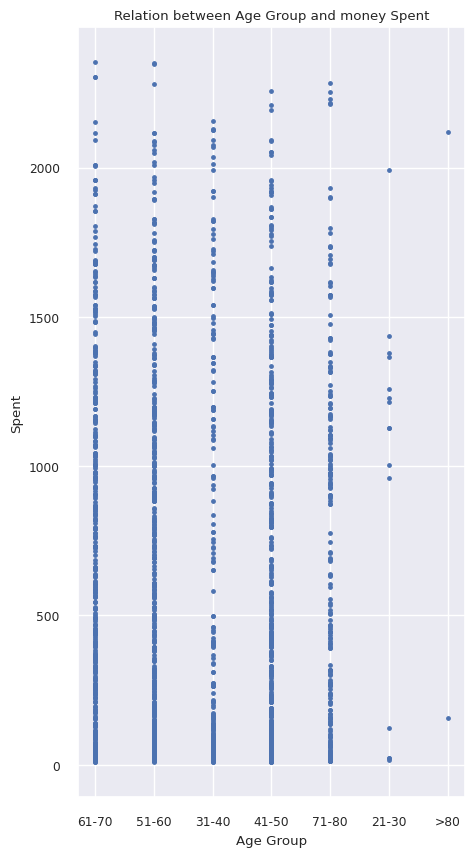

In [74]:
# Create a dataframe for each attribute
x_ageg = campaign['Age Group'].copy()
y_spent = campaign['Spent'].copy()

# Scatter plot
plt.figure(figsize=(5, 10))
plt.scatter(x_ageg, y_spent, s=6)

plt.xlabel('Age Group')
plt.ylabel('Spent')
plt.title('Relation between Age Group and money Spent')
plt.show()

Παρατήρηση: Στις ηλικιακές ομάδες 61-70 και 51-60 βλέπουμε αυξημένη πυκνότητα σημείων καθώς και τις πιο υψηλές τιμές στον άξονα 'Spent'. Άρα εκεί βρίσκεται σημαντικό μερίδιο πελατών που μάλιστα ξοδεύουν και μεγάλα ποσά. Αντίθετα, στις ηλικιακές ομάδες 21-30 και >80, υπάρχουν ελάχιστοι πελάτες.

6. Τι σχέση έχει το εισόδημα Income με το χαρακτηριστικό Spent των αγορών;

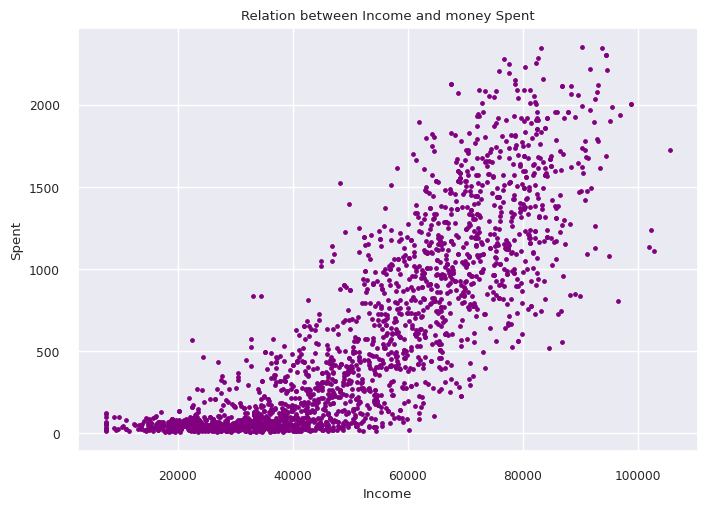

In [75]:
x_income = campaign['Income'].copy()

plt.scatter(x_income, y_spent, s=6, c='purple')

plt.xlabel('Income')
plt.ylabel('Spent')
plt.title('Relation between Income and money Spent')
plt.show()

Παρατήρηση: Οι πελάτες με εισόδημα μεγαλύτερο των 50000 ξοδεύουν γραμμικά, όπως θα περιμέναμε, δηλαδή όσο μεγαλύτερο το εισόδημά τους, τόσο περισσότερα τα ποσά που ξοδεύουν. Ωστόσο, βλέπουμε ότι στα εισοδήματα κάτω των 50000 υπάρχει πυκνή κατανομή των εξόδων σε ποσά μικρότερα των 500.

7. Ποια είναι η σχέση μεταξύ της εκπαίδευσης και του εισοδήματος;

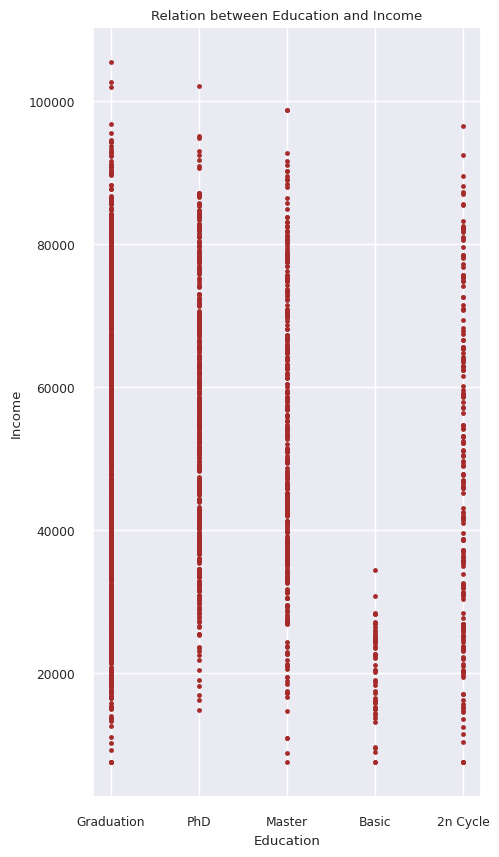

In [76]:
x_edu = campaign['Education'].copy()
y_income = campaign[['Income']].copy()

plt.figure(figsize=(5, 10))
plt.scatter(x_edu, y_income, s=6, c='brown')

plt.xlabel('Education')
plt.ylabel('Income')
plt.title('Relation between Education and Income')
plt.show()

Παρατήρηση: Γίνεται εμφανές πως στο διάστημα [20000-80000] βρίσκεται πληθώρα πελατών με πρώτο πτυχίο, όσοι έχουν διδακτορικό έχουν και μεγαλύτερο κατώτατο μισθό, όσοι έχουν βασική εκπαίδευση βρίσκονται με διαφορά σε χαμηλότερα εισοδήματα από τους υπόλοιπους.

10.Ποια είναι η σχέση μεταξύ του εισοδήματος και του Living_With;

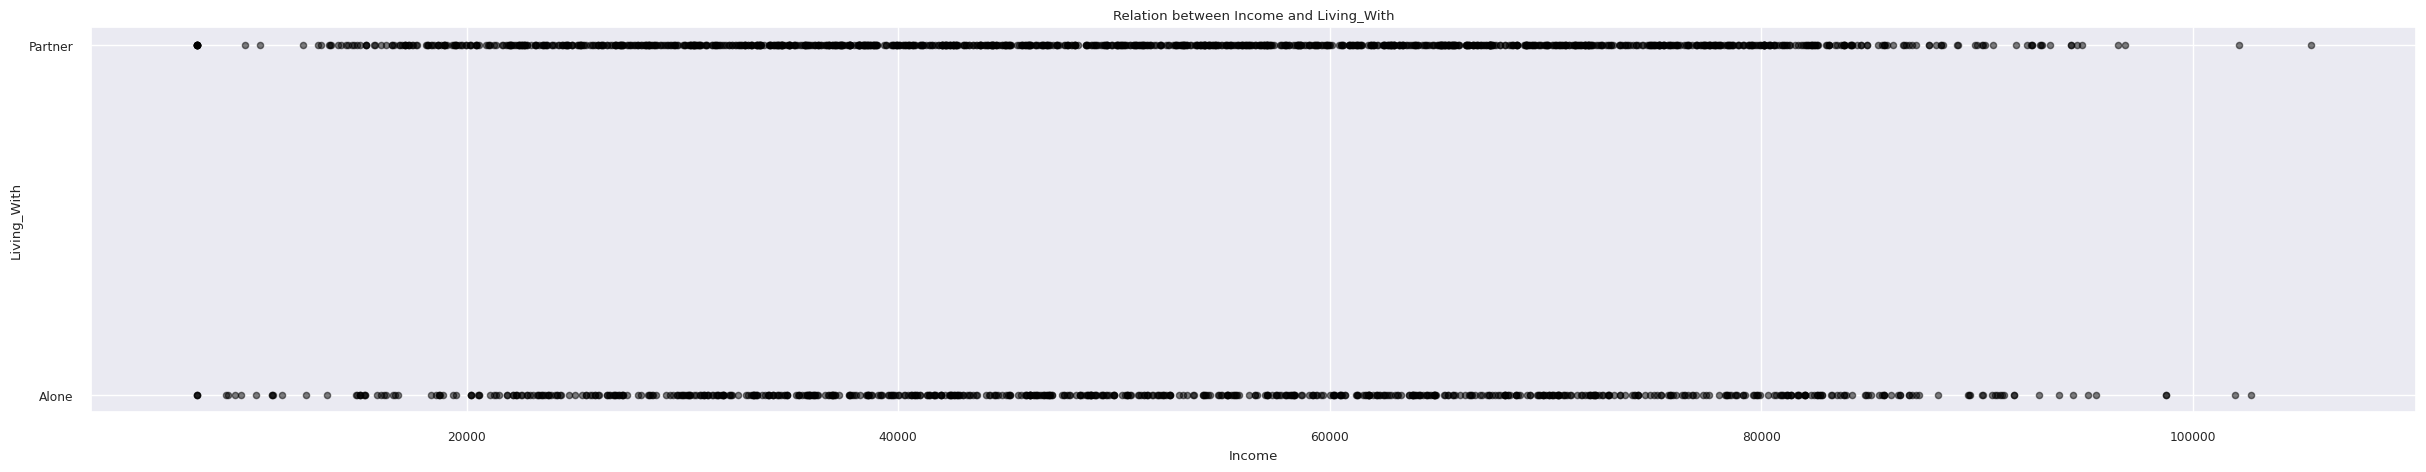

In [77]:
y_living_with = campaign['Living_With'].copy()
plt.figure(figsize=(30, 5))
plt.scatter(x_income, y_living_with, s=20, alpha=0.5, c='black')

plt.xlabel('Income')
plt.ylabel('Living_With')
plt.title('Relation between Income and Living_With')
plt.show()

Παρατήρηση: Βλέπουμε πως μέχρι τα 20000, υπάρχουν λιγότεροι πελάτες χωρίς σύντροφο. Μέχρι τα 80000 υπάρχουν πολλοί πελάτες με σύντροφο, ενώ και μετά τα 80000, όσοι έχουν σύντροφο είναι περισσότεροι και βγάζουν και περισσότερα από όσους είναι μόνοι.

14. Σχεδιάστε το ιστόγραμμα για τη στήλη NumDealsPurchases.

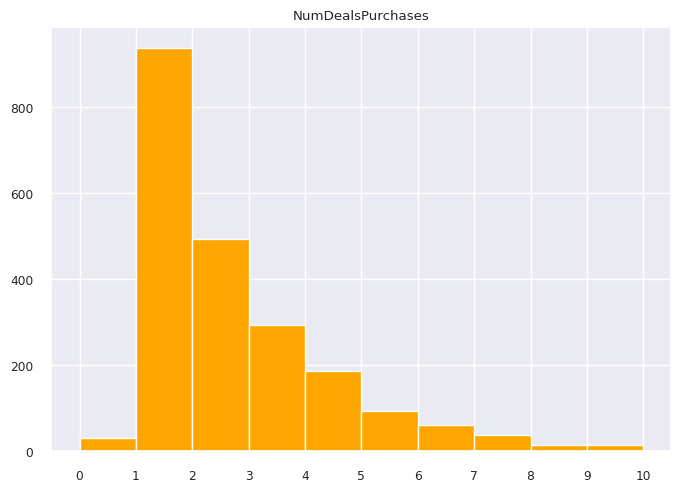

In [78]:
# Make a copy of column
deals_hist = campaign[['NumDealsPurchases']].copy()

# Histogram plot
deals_hist.hist(color='orange', bins=10)
plt.xticks(np.arange(11))
plt.show()

Παρατήρηση: Οι περισσότεροι πελάτες έχουνε κάνει 1 αγορά με έκπτωση.

15.Σχεδιάστε το ιστόγραμμα για τη στήλη Income.

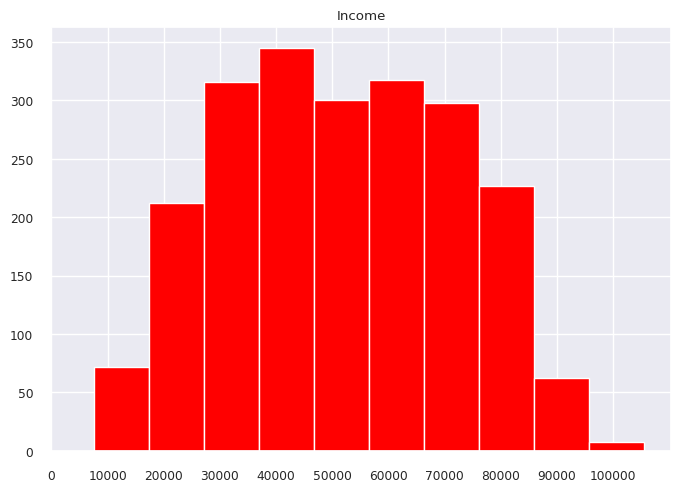

In [79]:
income_hist = campaign[['Income']].copy()

income_hist.hist(color='red', bins=10)
plt.xticks(np.arange(0, 110000, 10000))
plt.show()

Παρατήτηση: Οι περισσότεροι πελάτες έχουν εισόδημα στα [40000-50000], ενώ ελάχιστοι ξεπερνούν τα 100000.

16.Σχεδιάστε το ιστόγραμμα για τη στήλη Kidhome.

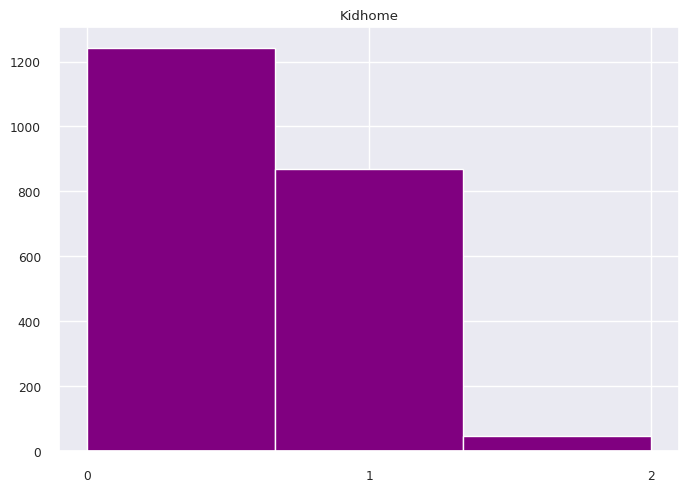

In [80]:
kidhome_hist = campaign[['Kidhome']].copy()

kidhome_hist.hist(color='purple',  bins=3)
plt.xticks(np.arange(3))
plt.show()

Παρατήρηση: Στα περισσότερα νοικοκυριά των πελατών δεν υπάρχει μικρό παιδί (χωρίς να μετράμε εφήβους).

17.Σχεδιάστε το ιστόγραμμα για τη στήλη Family_Size.

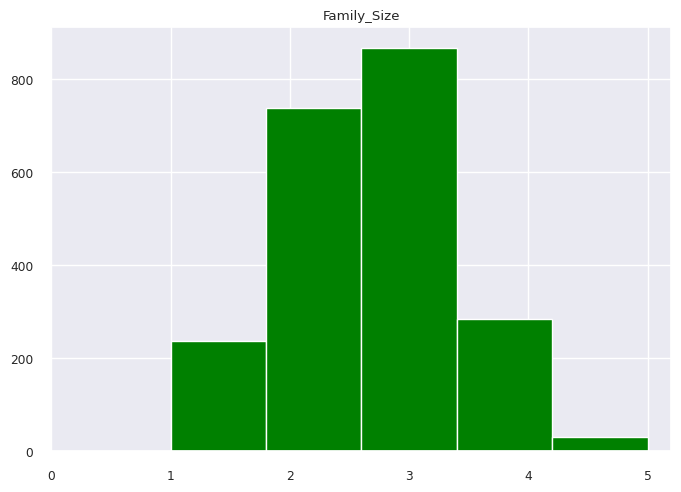

In [81]:
fam_hist = campaign[['Family_Size']].copy()

fam_hist.hist(color='green', bins=5)
plt.xticks(np.arange(6))
plt.show()

Παρατήρηση: Τα περισσότερα νοικοκυριά είναι τριμελή.

###**Ζητούμενο 7**: Principal component analysis (PCA)
Εφαρμόζουμε one hot encoding στα κατηγορικά χαρακτηριστικά, παίρνουμε μόνο τις στήλες με αριθμητικές τιμές και από αυτές αφαιρούμε εκείνες που σχετίζονται με προσφορές και προωθητικές ενέργειες, καθώς και των περιττών συσχετισμένων χαρακτηριστικών. Πραγματοποιούμε Standardization και χρησιμοποιούμε την μέθοδο PCA για να μειώσουμε τις διαστάσεις σε 3 components.

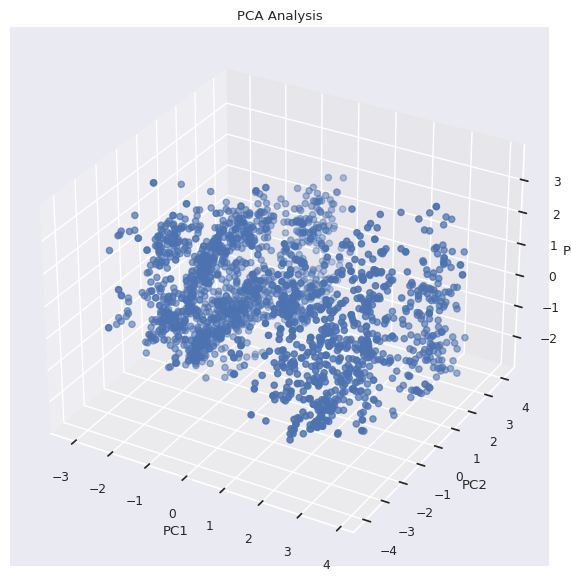

In [82]:
# One hot encoding of these 3 categorical attributes
campaign = pd.get_dummies(campaign, columns=['Education', 'Marital_Status', 'Living_With'])

# Create a dataframe copy and delete offers, promos and correlated attributes
copy_campaign = campaign.copy()

copy_campaign = copy_campaign.select_dtypes(include='number')

drop_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', \
             'AcceptedCmp5', 'Complain', 'Response', 'Kidhome', 'Teenhome', 'Recency',
       'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
       'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Z_CostContact', 'Z_Revenue', 'ID', 'Year_Birth', 'Is_Parent']

copy_campaign = copy_campaign.drop(drop_cols, axis=1)

# Standardization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(copy_campaign)

# PCA
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)

# Scatter plot
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection='3d')

ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2])

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA Analysis')

plt.show()

###**Ζητούμενο 8**: Clustering

Εφαρμόζουμε την μέθοδο ELBOW για τον προσδιορισμό του αριθμού των συστάδων που πρέπει να σχηματιστούν.

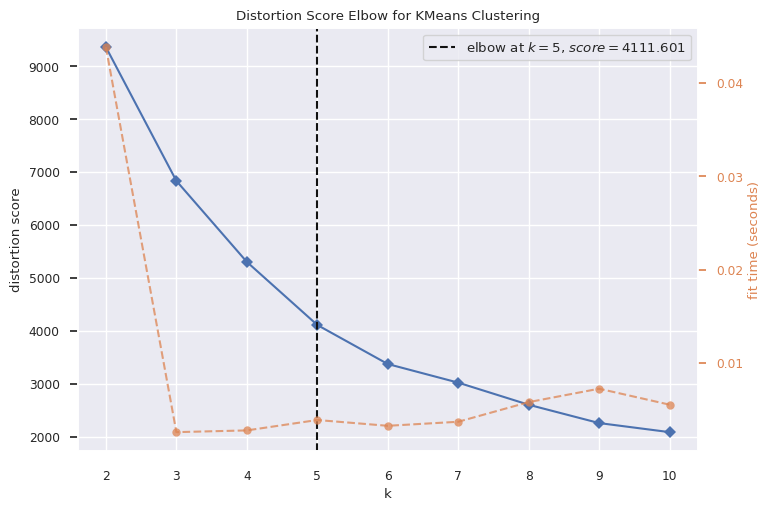

In [83]:
# Apply ELBOW method
model = KMeans(n_init='auto')
# k is range of number of clusters
visualizer = KElbowVisualizer(model, k=(10))
visualizer.fit(x_pca)
visualizer.show()

# Number of clusters
n_clusters = visualizer.elbow_value_

K-Means Clustering

KMeans silhouette score: 0.4008730883096247


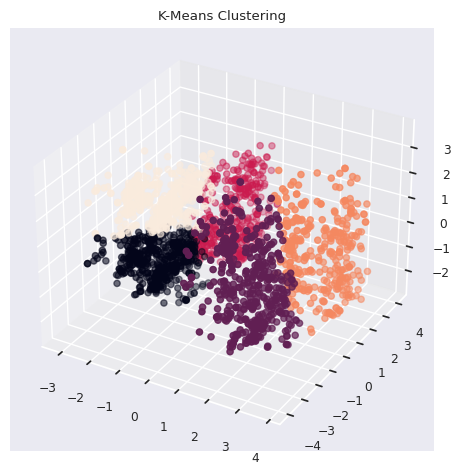

In [84]:
# Perform KMeans Clustering for given number of clusters
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
kmeans.fit(x_pca)
kmeans_labels = kmeans.labels_

# Obtain silhouette score
kmeans_silhouette = silhouette_score(x_pca, kmeans_labels)
print('KMeans silhouette score:', kmeans_silhouette)

# Scatter plot of the data colored by the kmeans labels
ax = plt.axes(projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=kmeans_labels)
plt.title('K-Means Clustering')
plt.show()

Agglomerative Clustering

Agglomerative silhouette score: 0.3476555364624291


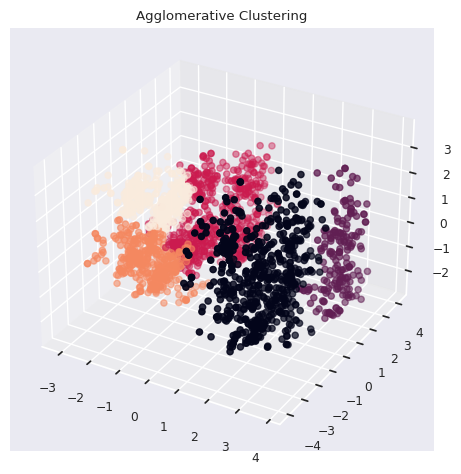

In [85]:
# Perform Agglomerative Clustering for given number of clusters
agglo = AgglomerativeClustering(n_clusters=n_clusters)
agglo.fit(x_pca)
agglo_labels = agglo.labels_

# Obtain silhouette score
agglo_silhouette = silhouette_score(x_pca, agglo_labels)
print('Agglomerative silhouette score:', agglo_silhouette)

# Scatter plot of the data colored by the agglomerative labels
ax = plt.axes(projection='3d')
ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=agglo_labels)
plt.title('Agglomerative Clustering')
plt.show()